In [1]:
import os
import numpy as np
import pandas as pd

from unidecode import unidecode

import tensorflow as tf
from tensorflow import keras

import pickle # saving and loading trained model
from os import path

# importing required libraries for normalizing data
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

# importing library for plotting
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn import metrics
from sklearn.metrics import accuracy_score # for calculating accuracy of model
from sklearn.model_selection import train_test_split # for splitting the dataset for training and testing
from sklearn.metrics import classification_report # for generating a classification report of model

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

from keras.layers import Dropout, Activation, Flatten, Convolution1D, Dropout, Reshape
from keras.layers import Dense # importing dense layer
from keras.models import Sequential #importing Sequential layer

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [3]:
#Define learning rate
lr=0.0001 

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    print(gpu, "\n")
else:
  print("No GPU device found")

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU') 



In [5]:
!nvidia-smi

Tue Jan 21 16:06:30 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.36                 Driver Version: 566.36         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 Ti   WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   49C    P8             19W /  200W |     642MiB /   8192MiB |      2%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [6]:
import pandas as pd
import glob

path = r'H:/Datasets/InSDN' # use your path
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, encoding='cp1252', index_col=None, header=0, low_memory=False)
    li.append(df)
    print("Read Completed for ", filename)
    
print("Reading Finished")
df = pd.concat(li, axis=0, ignore_index=True)

Read Completed for  H:/Datasets/InSDN\metasploitable-2.csv
Read Completed for  H:/Datasets/InSDN\Normal_data.csv
Read Completed for  H:/Datasets/InSDN\OVS.csv
Reading Finished


In [7]:
df.describe()

,Src Port,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,343889.000000,343889.000000,343889.000000,3.438890e+05,343889.000000,343889.000000,3.438890e+05,3.438890e+05,343889.000000,343889.000000,...,343889.000000,343889.0,3.438890e+05,3.438890e+05,3.438890e+05,3.438890e+05,3.438890e+05,3.438890e+05,3.438890e+05,3.438890e+05
mean,21982.659541,8072.495366,4.961767,6.737171e+06,6.160331,6.119012,7.310557e+02,8.335005e+03,115.689356,4.447778,...,1.441541,0.0,6.385104e+04,3.105350e+04,1.086384e+05,4.185579e+04,4.708172e+06,1.443613e+05,4.843965e+06,4.581512e+06
std,23669.464108,16275.407358,4.862608,2.183354e+07,1554.168988,105.863392,6.965289e+04,3.429719e+05,666.519811,31.285832,...,39.470056,0.0,7.852718e+05,5.035601e+05,1.220601e+06,6.672299e+05,1.616113e+07,1.653491e+06,1.641612e+07,1.604560e+07
min,0.000000,0.000000,0.000000,-1.540000e+02,0.000000,1.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,...,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000,0.000000,0.000000,1.700000e+01,0.000000,2.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,...,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,443.000000,80.000000,6.000000,2.530000e+03,0.000000,2.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,...,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,43920.000000,2495.000000,6.000000,1.208600e+04,2.000000,4.000000,3.000000e+01,3.000000e+01,30.000000,0.000000,...,1.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,65518.000000,65389.000000,17.000000,1.200000e+08,910748.000000,34094.000000,3.160000e+07,1.070000e+08,64239.000000,3900.000000,...,11180.000000,0.0,1.040000e+08,6.830000e+07,1.040000e+08,1.040000e+08,1.200000e+08,7.300000e+07,1.200000e+08,1.200000e+08


In [8]:
df.head()

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,192.168.3.130-200.175.2.130-38694-4444-6,192.168.3.130,38694,200.175.2.130,4444,6,10/1/2020 5:02,269709,4,5,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,U2R
1,192.168.3.130-200.175.2.130-38693-4444-6,192.168.3.130,38693,200.175.2.130,4444,6,10/1/2020 5:02,268599,2,3,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,U2R
2,192.168.3.130-200.175.2.130-3632-33747-6,200.175.2.130,33747,192.168.3.130,3632,6,10/1/2020 5:02,22194,5,5,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,U2R
3,192.168.3.130-200.175.2.130-8180-38745-6,200.175.2.130,38745,192.168.3.130,8180,6,10/1/2020 1:39,9556,4,4,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BFA
4,192.168.3.130-200.175.2.130-8180-37217-6,200.175.2.130,37217,192.168.3.130,8180,6,10/1/2020 1:39,8782,4,4,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BFA


In [9]:
import re

# Function to clean the labels
def clean_label(label):
    # Replace non-ASCII characters with a hyphen
    label = re.sub(r'[^\x00-\x7F]+', '-', label)
    return label.strip()  # Optional: Strip leading and trailing whitespace

# Apply the function to the DataFrame
df['Label'] = df['Label'].apply(clean_label)


df["Label"].value_counts()

DDoS          121942
Probe          98129
Normal         68424
DoS            53616
BFA             1405
Web-Attack       192
BOTNET           164
U2R               17
Name: Label, dtype: int64

In [10]:
print(df.shape)

(343889, 84)


In [11]:
from scipy.stats import zscore

def expand_categories(values):
    result = []
    s = values.value_counts()
    t = float(len(values))
    for v in s.index:
        result.append("{}:{}%".format(v,round(100*(s[v]/t),2)))
    return "[{}]".format(",".join(result))
        
def analyze(df):
    print()
    cols = df.columns.values
    total = float(len(df))

    print("{} rows".format(int(total)))
    for col in cols:
        uniques = df[col].unique()
        unique_count = len(uniques)
        if unique_count>100:
            print("** {}:{} ({}%)".format(col,unique_count,int(((unique_count)/total)*100)))
        else:
            print("** {}:{}".format(col,expand_categories(df[col])))
            expand_categories(df[col])

In [12]:
useless_columns = ['Flow ID', 'Timestamp', 'Src IP', 'Dst IP', 'Src Port', 'Dst Port']
df.drop(labels=useless_columns, axis='columns', inplace=True)

#drop na values and reset index
data_clean = df.dropna().reset_index()

# Checkng for DUPLICATE values
data_clean.drop_duplicates(keep='first', inplace = True)

data_clean['Label'].value_counts()

print("Read {} rows.".format(len(data_clean)))

Read 343889 rows.


In [13]:
analyze(data_clean)


343889 rows
** index:343889 (100%)
** Protocol:[6:54.68%,0:35.43%,17:9.89%]
** Flow Duration:85380 (24%)
** Tot Fwd Pkts:569 (0%)
** Tot Bwd Pkts:699 (0%)
** TotLen Fwd Pkts:5602 (1%)
** TotLen Bwd Pkts:7585 (2%)
** Fwd Pkt Len Max:2132 (0%)
** Fwd Pkt Len Min:[0:90.5%,34:1.41%,30:1.33%,32:1.13%,33:0.96%,95:0.85%,36:0.52%,40:0.44%,35:0.41%,42:0.26%,38:0.22%,51:0.21%,50:0.19%,37:0.18%,31:0.15%,45:0.14%,39:0.14%,43:0.11%,46:0.09%,174:0.09%,47:0.09%,60:0.08%,48:0.07%,44:0.06%,29:0.06%,49:0.04%,178:0.04%,22:0.04%,41:0.03%,28:0.03%,27:0.02%,137:0.01%,1300:0.01%,2600:0.01%,200:0.0%,52:0.0%,86:0.0%,90:0.0%,65:0.0%,53:0.0%,77:0.0%,83:0.0%,25:0.0%,498:0.0%,55:0.0%,59:0.0%,3900:0.0%,1210:0.0%,161:0.0%,58:0.0%,156:0.0%,247:0.0%,61:0.0%,152:0.0%,23:0.0%,133:0.0%,476:0.0%,207:0.0%,488:0.0%,54:0.0%,509:0.0%,3810:0.0%,519:0.0%,2510:0.0%,154:0.0%,1211:0.0%,327:0.0%,274:0.0%,2521:0.0%,309:0.0%,317:0.0%,436:0.0%,1:0.0%,5:0.0%,10:0.0%,57:0.0%]
** Fwd Pkt Len Mean:9698 (2%)
** Fwd Pkt Len Std:11879 (3%)


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder



#drop na values and reset index
data_clean = data_clean.dropna().reset_index()

# label encoding
labelencoder = LabelEncoder()
data_clean['Label'] = labelencoder.fit_transform(data_clean['Label'])

data_clean['Label'].value_counts()

2    121942
5     98129
4     68424
3     53616
0      1405
7       192
1       164
6        17
Name: Label, dtype: int64

In [15]:
print(data_clean.shape)

(343889, 80)


In [16]:
data_np = data_clean.to_numpy(dtype="float32")

#drop inf values
data_np = data_np[~np.isinf(data_np).any(axis=1)]

# Separate features (X) and target (Y)
X = data_np[:, :-1]  # All columns except the last one
enc = OneHotEncoder()
Y = enc.fit_transform(data_np[:, -1:]).toarray()  # One-hot encode the last column (target)

In [17]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data set into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(
    X_scaled, Y, test_size=0.25, random_state=2, shuffle=True)

_features = X.shape[1]
n_classes = Y.shape[1]

print('X.shape = ',X.shape)
print('Y.shape = ',Y.shape)
print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', Y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',Y_test.shape)

X.shape =  (343889, 79)
Y.shape =  (343889, 8)
X_train.shape =  (257916, 79)
y_train.shape =  (257916, 8)
X_test.shape =  (85973, 79)
y_test.shape =  (85973, 8)


In [18]:
print("X Shape: ", X.shape)
print("Y Shape: ", Y.shape)

X Shape:  (343889, 79)
Y Shape:  (343889, 8)


In [19]:
data = df.iloc[:,1:-1]

In [20]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
data.iloc[:,0] = label_encoder.fit_transform(data.iloc[:,0]).astype('float64')

In [21]:
corr = data.corr()

<AxesSubplot:>

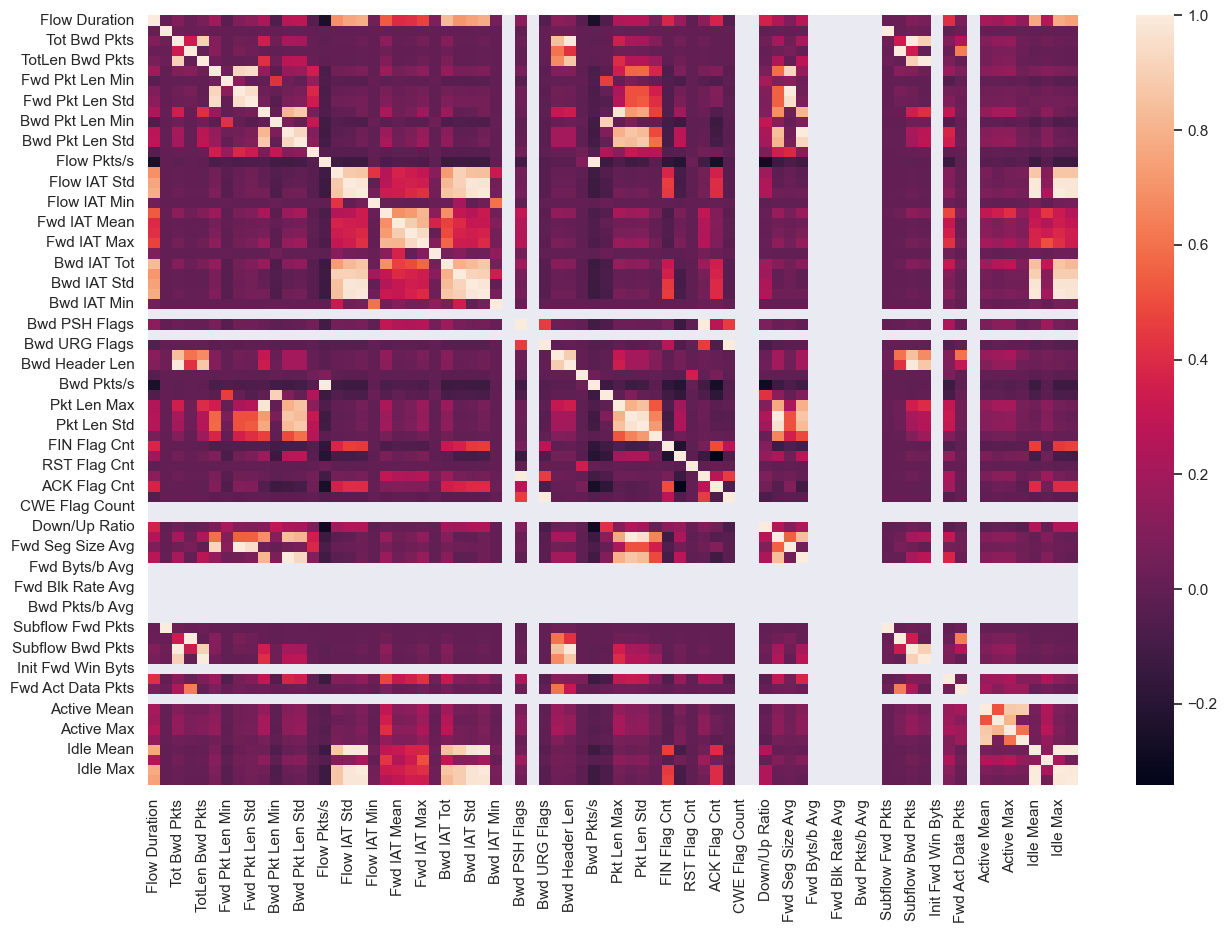

In [22]:
import seaborn as sns

sns.set(rc = {'figure.figsize':(15,10)})
sns.heatmap(corr)

# IO-DCNN

In [23]:
from keras.models import Sequential
from keras import callbacks
from keras.layers import Dense, Activation, Flatten, Convolution1D, Dropout, MaxPooling1D
from sklearn import metrics
from hyperopt import fmin, hp, tpe, Trials, STATUS_OK
from hyperopt.plotting import main_plot_history, main_plot_vars
import uuid
import gc
from tensorflow import keras
import tensorflow as tf

K = keras.backend

X_train = X_train.reshape(X_train.shape[0], _features, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], _features, 1).astype('float32')


# CNN Model
model = Sequential()
model.add(Convolution1D(filters=128, kernel_size=6, activation='relu', input_shape=(_features, 1)))
model.add(Convolution1D(filters=96, kernel_size=6, activation='relu'))

model.add(MaxPooling1D(pool_size=2, strides=1, padding='same'))


model.add(Convolution1D(filters=64, kernel_size=6, activation='relu'))

model.add(MaxPooling1D(pool_size=2, strides=1, padding='same'))

model.add(Flatten())

model.add(Dense(96, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(n_classes, activation='softmax'))

model.summary() 

opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['accuracy'])

   
history = model.fit(X_train, Y_train,
                              batch_size=128,
                              epochs=10,
                              verbose=True, 
                              validation_data=(X_test, Y_test))  

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 74, 128)           896       
                                                                 
 conv1d_1 (Conv1D)           (None, 69, 96)            73824     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 69, 96)           0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 64, 64)            36928     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 64, 64)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 4096)              0

In [24]:
#y_pred = model.predict_classes(X_test)
y_pred = np.argmax(model.predict(X_test), axis=-1)
balanced_score = metrics.balanced_accuracy_score(np.argmax(Y_test, axis=1), y_pred) * 100
    
best_loss = np.amin(history.history['val_loss']) 
print('Best loss: {}'.format(best_loss))
print('Balanced Acc loss: {}'.format(balanced_score))
    
    
import tensorflow.keras.backend as K
print('Learning Rate - ')
print(K.eval(model.optimizer.lr)) 
print('==================================')

2687/2687 [==============================] - 4s 1ms/step
Best loss: 0.012108603492379189
Balanced Acc loss: 85.3892509945838
Learning Rate - 
1e-04


In [25]:
import datetime as dt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn import preprocessing
import time

start = dt.datetime.now()


escore = model.evaluate(X_test, Y_test, batch_size=32)

# Measure inference time
start_time = time.time()
pred = model.predict(X_test)
end_time = time.time()


pred = np.argmax(pred,axis=1)
y_eval = np.argmax(Y_test,axis=1)

score = metrics.accuracy_score(y_eval, pred)
rscore = recall_score(y_eval, pred, average='weighted')
ascore = precision_score(y_eval, pred, average='weighted')
f1score= f1_score(y_eval, pred, average='weighted') #F1 = 2 * (precision * recall) / (precision + recall) for manual

lb = preprocessing.LabelBinarizer()
lb.fit(y_eval)
y_eval = lb.transform(y_eval)
pred = lb.transform(pred)
roc_score = roc_auc_score(y_eval, pred)

print('Completed')
print('Time taken:',dt.datetime.now()-start)

inference_time = end_time - start_time
# Given data
validation_time_total = inference_time  # Total validation time in seconds
validation_samples = X_test.shape  # Number of validation samples
batch_size = 128  # Batch size

# Calculate the number of batches
#num_batches = np.ceil(validation_samples / batch_size)
num_batches = np.ceil(validation_samples[0] / batch_size)

# Calculate time per batch during inference
time_per_batch = validation_time_total / num_batches

# Calculate detection time per sample
detection_time_per_sample = time_per_batch / batch_size

# Print results
print(f"Number of Batches: {num_batches}")
print(f"Time per Batch (Inference): {time_per_batch:.6f} seconds")
print(f"Detection Time per Sample: {detection_time_per_sample:.6f} seconds")



print("Time for fitting: {:.2f} seconds".format(inference_time))

print("Validation score: {}".format(score))
print("Evaluation score: {}".format(escore))
print("Recall score: {}".format(rscore))
print("Precision score: {}".format(ascore))
print("F1 Measure score: {}".format(f1score))
print("ROC-AUC score: {}".format(roc_score))

2687/2687 [==============================] - 4s 1ms/step
Completed
Time taken: 0:00:11.137666
Number of Batches: 672.0
Time per Batch (Inference): 0.006628 seconds
Detection Time per Sample: 0.000052 seconds
Time for fitting: 4.45 seconds
Validation score: 0.9993486327102695
Evaluation score: [0.014009062200784683, 0.9993486404418945]
Recall score: 0.9993486327102695
Precision score: 0.9993335584082749
F1 Measure score: 0.9993336457427616
ROC-AUC score: 0.9268975018478165


C:\Users\Maruata\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
# Plot for training and validation loss
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

In [27]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test = Y_test.argmax(axis=1)

2687/2687 [==============================] - 3s 1ms/step


In [28]:
pred.shape
y_test.shape

(85973,)

In [29]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sn

confMat = confusion_matrix(y_test, pred)
confMat

array([[  364,     0,     0,     0,     0,     0,     0,     0],
       [    0,    42,     0,     0,     0,     0,     0,     0],
       [    0,     0, 30495,     0,     1,     2,     0,     0],
       [    0,     0,     0, 13421,     0,     5,     0,     0],
       [    4,     0,     4,     3, 17041,     1,     0,     0],
       [    0,     4,     0,    16,     3, 24514,     0,     2],
       [    0,     0,     0,     3,     0,     0,     0,     0],
       [    0,     6,     0,     1,     0,     1,     0,    40]],
      dtype=int64)

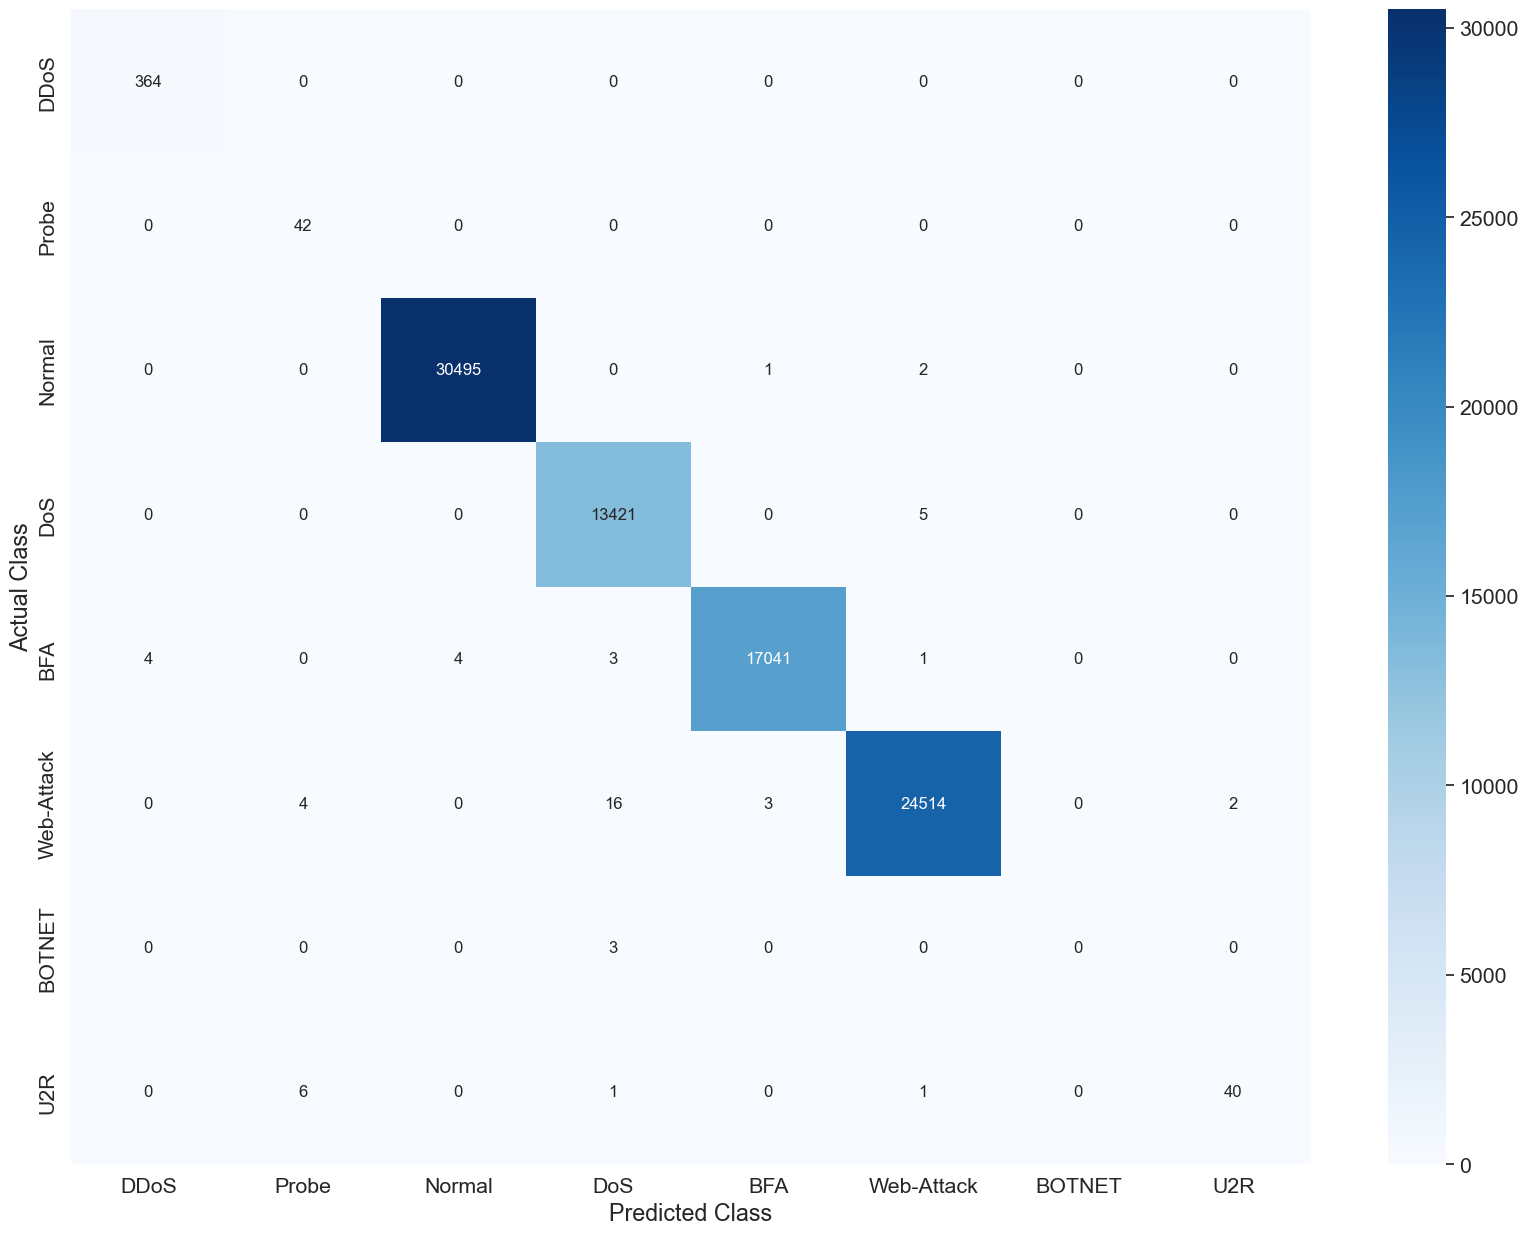

In [30]:
cf_matrix = confusion_matrix(y_test, pred)
cm_df = pd.DataFrame(cf_matrix)

labels = ['DDoS', 'Probe', 'Normal', 'DoS', 'BFA', 'Web-Attack', 'BOTNET', 'U2R']

plt.figure(figsize=(20,15))
sn.set(font_scale=1.4)
sn.heatmap(cm_df, annot=True, annot_kws={"size":12}, fmt='g', xticklabels=labels, yticklabels=labels, cmap='Blues')

#sn.heatmap(cm_df, annot=True, annot_kws={"size":12}, fmt='g', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
    
plt.show() 

# IO-DCNN - Adagrad

In [31]:
from keras.models import Sequential
from keras import callbacks
from keras.layers import Dense, Activation, Flatten, Convolution1D, Dropout, MaxPooling1D
from sklearn import metrics
from hyperopt import fmin, hp, tpe, Trials, STATUS_OK
from hyperopt.plotting import main_plot_history, main_plot_vars
import uuid
import gc
from tensorflow import keras
import tensorflow as tf

K = keras.backend

X_train = X_train.reshape(X_train.shape[0], _features, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], _features, 1).astype('float32')


# CNN Model
model = Sequential()
model.add(Convolution1D(filters=128, kernel_size=6, activation='relu', input_shape=(_features, 1)))
model.add(Convolution1D(filters=96, kernel_size=6, activation='relu'))

model.add(MaxPooling1D(pool_size=2, strides=1, padding='same'))


model.add(Convolution1D(filters=64, kernel_size=6, activation='relu'))

model.add(MaxPooling1D(pool_size=2, strides=1, padding='same'))

model.add(Flatten())


model.add(Dense(96, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))


model.add(Dense(n_classes, activation='softmax'))

model.summary() 

opt = keras.optimizers.Adagrad(learning_rate=lr)
model.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['accuracy'])

    
history = model.fit(X_train, Y_train,
                              batch_size=128,
                              epochs=10,
                              verbose=True, 
                              validation_data=(X_test, Y_test))  

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 74, 128)           896       
                                                                 
 conv1d_4 (Conv1D)           (None, 69, 96)            73824     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 69, 96)           0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 64, 64)            36928     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 64, 64)           0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 4096)             

In [32]:
#y_pred = model.predict_classes(X_test)
y_pred = np.argmax(model.predict(X_test), axis=-1)
balanced_score = metrics.balanced_accuracy_score(np.argmax(Y_test, axis=1), y_pred) * 100
    
best_loss = np.amin(history.history['val_loss']) 
print('Best loss: {}'.format(best_loss))
print('Balanced Acc loss: {}'.format(balanced_score))
    
    
import tensorflow.keras.backend as K
print('Learning Rate - ')
print(K.eval(model.optimizer.lr)) 
print('==================================')

2687/2687 [==============================] - 3s 1ms/step
Best loss: 0.2148435264825821
Balanced Acc loss: 47.68516539579017
Learning Rate - 
1e-04


In [33]:
import datetime as dt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn import preprocessing
import time

start = dt.datetime.now()


escore = model.evaluate(X_test, Y_test, batch_size=32)

# Measure inference time
start_time = time.time()
pred = model.predict(X_test)
end_time = time.time()


pred = np.argmax(pred,axis=1)
y_eval = np.argmax(Y_test,axis=1)

score = metrics.accuracy_score(y_eval, pred)
rscore = recall_score(y_eval, pred, average='weighted')
ascore = precision_score(y_eval, pred, average='weighted')
f1score= f1_score(y_eval, pred, average='weighted') #F1 = 2 * (precision * recall) / (precision + recall) for manual

lb = preprocessing.LabelBinarizer()
lb.fit(y_eval)
y_eval = lb.transform(y_eval)
pred = lb.transform(pred)
roc_score = roc_auc_score(y_eval, pred)

print('Completed')
print('Time taken:',dt.datetime.now()-start)

inference_time = end_time - start_time
# Given data
validation_time_total = inference_time  # Total validation time in seconds
validation_samples = X_test.shape  # Number of validation samples
batch_size = 128  # Batch size

# Calculate the number of batches
#num_batches = np.ceil(validation_samples / batch_size)
num_batches = np.ceil(validation_samples[0] / batch_size)

# Calculate time per batch during inference
time_per_batch = validation_time_total / num_batches

# Calculate detection time per sample
detection_time_per_sample = time_per_batch / batch_size

# Print results
print(f"Number of Batches: {num_batches}")
print(f"Time per Batch (Inference): {time_per_batch:.6f} seconds")
print(f"Detection Time per Sample: {detection_time_per_sample:.6f} seconds")



print("Time for fitting: {:.2f} seconds".format(inference_time))

print("Validation score: {}".format(score))
print("Evaluation score: {}".format(escore))
print("Recall score: {}".format(rscore))
print("Precision score: {}".format(ascore))
print("F1 Measure score: {}".format(f1score))
print("ROC-AUC score: {}".format(roc_score))

2687/2687 [==============================] - 3s 1ms/step
Completed
Time taken: 0:00:09.853526
Number of Batches: 672.0
Time per Batch (Inference): 0.006118 seconds
Detection Time per Sample: 0.000048 seconds
Time for fitting: 4.11 seconds
Validation score: 0.9477045118816373
Evaluation score: [0.2148391604423523, 0.9477044939994812]
Recall score: 0.9477045118816373
Precision score: 0.9471446869290874
F1 Measure score: 0.9455037443591835
ROC-AUC score: 0.7341971423052258


C:\Users\Maruata\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test = Y_test.argmax(axis=1)

2687/2687 [==============================] - 3s 1ms/step


In [35]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sn

confMat = confusion_matrix(y_test, pred)
confMat

array([[    0,     0,     0,   286,     0,    78,     0,     0],
       [    0,     0,     0,    19,     0,    23,     0,     0],
       [    0,     0, 30354,    96,    27,    21,     0,     0],
       [    0,     0,    10, 13008,   235,   173,     0,     0],
       [    0,     0,   117,   278, 16626,    32,     0,     0],
       [    0,     0,   970,  2072,     8, 21489,     0,     0],
       [    0,     0,     0,     0,     0,     3,     0,     0],
       [    0,     0,     0,    42,     1,     5,     0,     0]],
      dtype=int64)

# IO-DCNN - Adamax

In [36]:
from keras.models import Sequential
from keras import callbacks
from keras.layers import Dense, Activation, Flatten, Convolution1D, Dropout, MaxPooling1D
from sklearn import metrics
from hyperopt import fmin, hp, tpe, Trials, STATUS_OK
from hyperopt.plotting import main_plot_history, main_plot_vars
import uuid
import gc
from tensorflow import keras
import tensorflow as tf

K = keras.backend

X_train = X_train.reshape(X_train.shape[0], _features, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], _features, 1).astype('float32')


# CNN Model
model = Sequential()
model.add(Convolution1D(filters=128, kernel_size=6, activation='relu', input_shape=(_features, 1)))
model.add(Convolution1D(filters=96, kernel_size=6, activation='relu'))

model.add(MaxPooling1D(pool_size=2, strides=1, padding='same'))


model.add(Convolution1D(filters=64, kernel_size=6, activation='relu'))

model.add(MaxPooling1D(pool_size=2, strides=1, padding='same'))

model.add(Flatten())


model.add(Dense(96, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))


model.add(Dense(n_classes, activation='softmax'))

model.summary() 

opt = keras.optimizers.Adamax(learning_rate=lr)
model.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['accuracy'])

    
history = model.fit(X_train, Y_train,
                              batch_size=128,
                              epochs=10,
                              verbose=True, 
                              validation_data=(X_test, Y_test))  

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 74, 128)           896       
                                                                 
 conv1d_7 (Conv1D)           (None, 69, 96)            73824     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 69, 96)           0         
 1D)                                                             
                                                                 
 conv1d_8 (Conv1D)           (None, 64, 64)            36928     
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 64, 64)           0         
 1D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 4096)             

In [37]:
#y_pred = model.predict_classes(X_test)
y_pred = np.argmax(model.predict(X_test), axis=-1)
balanced_score = metrics.balanced_accuracy_score(np.argmax(Y_test, axis=1), y_pred) * 100
    
best_loss = np.amin(history.history['val_loss']) 
print('Best loss: {}'.format(best_loss))
print('Balanced Acc loss: {}'.format(balanced_score))
    
    
import tensorflow.keras.backend as K
print('Learning Rate - ')
print(K.eval(model.optimizer.lr)) 
print('==================================')

2687/2687 [==============================] - 4s 1ms/step
Best loss: 0.03028947114944458
Balanced Acc loss: 56.52821406705522
Learning Rate - 
1e-04


In [38]:
import datetime as dt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn import preprocessing
import time

start = dt.datetime.now()


escore = model.evaluate(X_test, Y_test, batch_size=32)

# Measure inference time
start_time = time.time()
pred = model.predict(X_test)
end_time = time.time()


pred = np.argmax(pred,axis=1)
y_eval = np.argmax(Y_test,axis=1)

score = metrics.accuracy_score(y_eval, pred)
rscore = recall_score(y_eval, pred, average='weighted')
ascore = precision_score(y_eval, pred, average='weighted')
f1score= f1_score(y_eval, pred, average='weighted') #F1 = 2 * (precision * recall) / (precision + recall) for manual

lb = preprocessing.LabelBinarizer()
lb.fit(y_eval)
y_eval = lb.transform(y_eval)
pred = lb.transform(pred)
roc_score = roc_auc_score(y_eval, pred)

print('Completed')
print('Time taken:',dt.datetime.now()-start)

inference_time = end_time - start_time
# Given data
validation_time_total = inference_time  # Total validation time in seconds
validation_samples = X_test.shape  # Number of validation samples
batch_size = 128  # Batch size

# Calculate the number of batches
#num_batches = np.ceil(validation_samples / batch_size)
num_batches = np.ceil(validation_samples[0] / batch_size)

# Calculate time per batch during inference
time_per_batch = validation_time_total / num_batches

# Calculate detection time per sample
detection_time_per_sample = time_per_batch / batch_size

# Print results
print(f"Number of Batches: {num_batches}")
print(f"Time per Batch (Inference): {time_per_batch:.6f} seconds")
print(f"Detection Time per Sample: {detection_time_per_sample:.6f} seconds")



print("Time for fitting: {:.2f} seconds".format(inference_time))

print("Validation score: {}".format(score))
print("Evaluation score: {}".format(escore))
print("Recall score: {}".format(rscore))
print("Precision score: {}".format(ascore))
print("F1 Measure score: {}".format(f1score))
print("ROC-AUC score: {}".format(roc_score))

2687/2687 [==============================] - 4s 1ms/step
Completed
Time taken: 0:00:11.365052
Number of Batches: 672.0
Time per Batch (Inference): 0.006666 seconds
Detection Time per Sample: 0.000052 seconds
Time for fitting: 4.48 seconds
Validation score: 0.9938236423063055
Evaluation score: [0.030289478600025177, 0.9938236474990845]
Recall score: 0.9938236423063055
Precision score: 0.9925155176795959
F1 Measure score: 0.9930662181487924
ROC-AUC score: 0.7821703648658385


C:\Users\Maruata\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [39]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test = Y_test.argmax(axis=1)

2687/2687 [==============================] - 4s 1ms/step


In [40]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sn

confMat = confusion_matrix(y_test, pred)
confMat

array([[  196,     0,     0,   145,    18,     5,     0,     0],
       [    0,     0,     0,     0,     0,    42,     0,     0],
       [    0,     0, 30493,     0,     1,     4,     0,     0],
       [   31,     0,     0, 13356,    19,    20,     0,     0],
       [    0,     0,    10,   140, 16892,    11,     0,     0],
       [    2,     0,     5,    20,     7, 24505,     0,     0],
       [    0,     0,     0,     1,     0,     2,     0,     0],
       [   25,     0,     0,    11,     1,    11,     0,     0]],
      dtype=int64)

# IO-DCNN - Nadam

In [41]:
from keras.models import Sequential
from keras import callbacks
from keras.layers import Dense, Activation, Flatten, Convolution1D, Dropout, MaxPooling1D
from sklearn import metrics
from hyperopt import fmin, hp, tpe, Trials, STATUS_OK
from hyperopt.plotting import main_plot_history, main_plot_vars
import uuid
import gc
from tensorflow import keras
import tensorflow as tf

K = keras.backend

X_train = X_train.reshape(X_train.shape[0], _features, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], _features, 1).astype('float32')


# CNN Model
model = Sequential()
model.add(Convolution1D(filters=128, kernel_size=6, activation='relu', input_shape=(_features, 1)))
model.add(Convolution1D(filters=96, kernel_size=6, activation='relu'))

model.add(MaxPooling1D(pool_size=2, strides=1, padding='same'))


model.add(Convolution1D(filters=64, kernel_size=6, activation='relu'))

model.add(MaxPooling1D(pool_size=2, strides=1, padding='same'))

model.add(Flatten())


model.add(Dense(96, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))


model.add(Dense(n_classes, activation='softmax'))

model.summary() 

opt = keras.optimizers.Nadam(learning_rate=lr)
model.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['accuracy'])

    
history = model.fit(X_train, Y_train,
                              batch_size=128,
                              epochs=10,
                              verbose=True, 
                              validation_data=(X_test, Y_test)) 

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 74, 128)           896       
                                                                 
 conv1d_10 (Conv1D)          (None, 69, 96)            73824     
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 69, 96)           0         
 1D)                                                             
                                                                 
 conv1d_11 (Conv1D)          (None, 64, 64)            36928     
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 64, 64)           0         
 1D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 4096)             

In [42]:
#y_pred = model.predict_classes(X_test)
y_pred = np.argmax(model.predict(X_test), axis=-1)
balanced_score = metrics.balanced_accuracy_score(np.argmax(Y_test, axis=1), y_pred) * 100
    
best_loss = np.amin(history.history['val_loss']) 
print('Best loss: {}'.format(best_loss))
print('Balanced Acc loss: {}'.format(balanced_score))
    
    
import tensorflow.keras.backend as K
print('Learning Rate - ')
print(K.eval(model.optimizer.lr)) 
print('==================================')

2687/2687 [==============================] - 4s 1ms/step
Best loss: 0.00643822131678462
Balanced Acc loss: 85.35192710951887
Learning Rate - 
1e-04


In [43]:
import datetime as dt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn import preprocessing
import time

start = dt.datetime.now()


escore = model.evaluate(X_test, Y_test, batch_size=32)

# Measure inference time
start_time = time.time()
pred = model.predict(X_test)
end_time = time.time()


pred = np.argmax(pred,axis=1)
y_eval = np.argmax(Y_test,axis=1)

score = metrics.accuracy_score(y_eval, pred)
rscore = recall_score(y_eval, pred, average='weighted')
ascore = precision_score(y_eval, pred, average='weighted')
f1score= f1_score(y_eval, pred, average='weighted') #F1 = 2 * (precision * recall) / (precision + recall) for manual

lb = preprocessing.LabelBinarizer()
lb.fit(y_eval)
y_eval = lb.transform(y_eval)
pred = lb.transform(pred)
roc_score = roc_auc_score(y_eval, pred)

print('Completed')
print('Time taken:',dt.datetime.now()-start)

inference_time = end_time - start_time
# Given data
validation_time_total = inference_time  # Total validation time in seconds
validation_samples = X_test.shape  # Number of validation samples
batch_size = 128  # Batch size

# Calculate the number of batches
#num_batches = np.ceil(validation_samples / batch_size)
num_batches = np.ceil(validation_samples[0] / batch_size)

# Calculate time per batch during inference
time_per_batch = validation_time_total / num_batches

# Calculate detection time per sample
detection_time_per_sample = time_per_batch / batch_size

# Print results
print(f"Number of Batches: {num_batches}")
print(f"Time per Batch (Inference): {time_per_batch:.6f} seconds")
print(f"Detection Time per Sample: {detection_time_per_sample:.6f} seconds")



print("Time for fitting: {:.2f} seconds".format(inference_time))

print("Validation score: {}".format(score))
print("Evaluation score: {}".format(escore))
print("Recall score: {}".format(rscore))
print("Precision score: {}".format(ascore))
print("F1 Measure score: {}".format(f1score))
print("ROC-AUC score: {}".format(roc_score))

2687/2687 [==============================] - 4s 1ms/step
Completed
Time taken: 0:00:11.237958
Number of Batches: 672.0
Time per Batch (Inference): 0.006682 seconds
Detection Time per Sample: 0.000052 seconds
Time for fitting: 4.49 seconds
Validation score: 0.9992904749165435
Evaluation score: [0.014342684298753738, 0.9992904663085938]
Recall score: 0.9992904749165435
Precision score: 0.9992553676757523
F1 Measure score: 0.999271500296979
ROC-AUC score: 0.9267053912650787


C:\Users\Maruata\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [44]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test = Y_test.argmax(axis=1)

2687/2687 [==============================] - 4s 1ms/step


In [45]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sn

confMat = confusion_matrix(y_test, pred)
confMat

array([[  363,     0,     0,     1,     0,     0,     0,     0],
       [    0,    42,     0,     0,     0,     0,     0,     0],
       [    0,     0, 30495,     1,     1,     1,     0,     0],
       [    0,     0,     0, 13423,     1,     2,     0,     0],
       [    9,     0,     5,     6, 17033,     0,     0,     0],
       [    0,     0,     4,    12,     2, 24516,     0,     5],
       [    0,     0,     0,     3,     0,     0,     0,     0],
       [    0,     2,     0,     1,     0,     5,     0,    40]],
      dtype=int64)

# IO-DCNN - SGD

In [46]:
from keras.models import Sequential
from keras import callbacks
from keras.layers import Dense, Activation, Flatten, Convolution1D, Dropout, MaxPooling1D
from sklearn import metrics
from hyperopt import fmin, hp, tpe, Trials, STATUS_OK
from hyperopt.plotting import main_plot_history, main_plot_vars
import uuid
import gc
from tensorflow import keras
import tensorflow as tf

K = keras.backend

X_train = X_train.reshape(X_train.shape[0], _features, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], _features, 1).astype('float32')


# CNN Model
model = Sequential()
model.add(Convolution1D(filters=128, kernel_size=6, activation='relu', input_shape=(_features, 1)))
model.add(Convolution1D(filters=96, kernel_size=6, activation='relu'))

model.add(MaxPooling1D(pool_size=2, strides=1, padding='same'))


model.add(Convolution1D(filters=64, kernel_size=6, activation='relu'))

model.add(MaxPooling1D(pool_size=2, strides=1, padding='same'))

model.add(Flatten())


model.add(Dense(96, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))


model.add(Dense(n_classes, activation='softmax'))

model.summary() 

opt = keras.optimizers.SGD(learning_rate=lr)
model.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['accuracy'])

    
history = model.fit(X_train, Y_train,
                              batch_size=128,
                              epochs=10,
                              verbose=True, 
                              validation_data=(X_test, Y_test)) 

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 74, 128)           896       
                                                                 
 conv1d_13 (Conv1D)          (None, 69, 96)            73824     
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 69, 96)           0         
 1D)                                                             
                                                                 
 conv1d_14 (Conv1D)          (None, 64, 64)            36928     
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 64, 64)           0         
 1D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 4096)             

In [47]:
#y_pred = model.predict_classes(X_test)
y_pred = np.argmax(model.predict(X_test), axis=-1)
balanced_score = metrics.balanced_accuracy_score(np.argmax(Y_test, axis=1), y_pred) * 100
    
best_loss = np.amin(history.history['val_loss']) 
print('Best loss: {}'.format(best_loss))
print('Balanced Acc loss: {}'.format(balanced_score))
    
    
import tensorflow.keras.backend as K
print('Learning Rate - ')
print(K.eval(model.optimizer.lr)) 
print('==================================')

2687/2687 [==============================] - 4s 1ms/step
Best loss: 0.29317712783813477
Balanced Acc loss: 44.75800496793683
Learning Rate - 
1e-04


In [48]:
import datetime as dt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn import preprocessing
import time

start = dt.datetime.now()


escore = model.evaluate(X_test, Y_test, batch_size=32)

# Measure inference time
start_time = time.time()
pred = model.predict(X_test)
end_time = time.time()


pred = np.argmax(pred,axis=1)
y_eval = np.argmax(Y_test,axis=1)

score = metrics.accuracy_score(y_eval, pred)
rscore = recall_score(y_eval, pred, average='weighted')
ascore = precision_score(y_eval, pred, average='weighted')
f1score= f1_score(y_eval, pred, average='weighted') #F1 = 2 * (precision * recall) / (precision + recall) for manual

lb = preprocessing.LabelBinarizer()
lb.fit(y_eval)
y_eval = lb.transform(y_eval)
pred = lb.transform(pred)
roc_score = roc_auc_score(y_eval, pred)

print('Completed')
print('Time taken:',dt.datetime.now()-start)

inference_time = end_time - start_time
# Given data
validation_time_total = inference_time  # Total validation time in seconds
validation_samples = X_test.shape  # Number of validation samples
batch_size = 128  # Batch size

# Calculate the number of batches
#num_batches = np.ceil(validation_samples / batch_size)
num_batches = np.ceil(validation_samples[0] / batch_size)

# Calculate time per batch during inference
time_per_batch = validation_time_total / num_batches

# Calculate detection time per sample
detection_time_per_sample = time_per_batch / batch_size

# Print results
print(f"Number of Batches: {num_batches}")
print(f"Time per Batch (Inference): {time_per_batch:.6f} seconds")
print(f"Detection Time per Sample: {detection_time_per_sample:.6f} seconds")



print("Time for fitting: {:.2f} seconds".format(inference_time))

print("Validation score: {}".format(score))
print("Evaluation score: {}".format(escore))
print("Recall score: {}".format(rscore))
print("Precision score: {}".format(ascore))
print("F1 Measure score: {}".format(f1score))
print("ROC-AUC score: {}".format(roc_score))

2687/2687 [==============================] - 4s 2ms/step
Completed
Time taken: 0:00:12.021977
Number of Batches: 672.0
Time per Batch (Inference): 0.007417 seconds
Detection Time per Sample: 0.000058 seconds
Time for fitting: 4.98 seconds
Validation score: 0.9219522408197922
Evaluation score: [0.2931692600250244, 0.9219522476196289]
Recall score: 0.9219522408197922
Precision score: 0.9219158531316056
F1 Measure score: 0.91609286798411
ROC-AUC score: 0.7169720582608354


C:\Users\Maruata\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [49]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test = Y_test.argmax(axis=1)

2687/2687 [==============================] - 5s 2ms/step


In [50]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sn

confMat = confusion_matrix(y_test, pred)
confMat

array([[    0,     0,     0,   189,     0,   175,     0,     0],
       [    0,     0,     0,     0,     0,    42,     0,     0],
       [    0,     0, 30354,     2,    93,    49,     0,     0],
       [    0,     0,     3,  8733,   459,  4231,     0,     0],
       [    0,     0,    87,   152, 16640,   174,     0,     0],
       [    0,     0,   977,    24,     2, 23536,     0,     0],
       [    0,     0,     0,     0,     0,     3,     0,     0],
       [    0,     0,     0,    42,     1,     5,     0,     0]],
      dtype=int64)